---
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: arrow
  pdf:
    documentclass: scrreprt
    links-as-notes: true
    reference-location: section
    toc: true
    toc-depth: 2
    lof: true
    lot: true
    number-sections: true
    fig-width: 8
    fig-height: 6

---

# Genetic Algorithm for GAP

## Algorithm Design

## Implementation Details


```{.java filename="GapSolution.java" #lst-gap-sol lst-cap="The solution class"}
package com.voyager.opt.metaheuristics.gap;

import lombok.Getter;

import java.util.Arrays;
import java.util.Random;
import java.util.stream.IntStream;

@Getter
public final class GapSolution {
  /**
   * reference to the instance to be solved
   */
  private final GapInstance instance;
  /**
   * dimension: 1 * numTasks
   * assigned agent index for each task
   */
  private final int[] agentAssignments;
  /**
   * dimension: 1 * numAgents
   * consumed capacity of each agent
   */
  private final int[] consumedCapacities;
  /**
   * total objective value
   */
  private int objective;
  /**
   * assignment cost, without penalties
   */
  private int assignmentCost;
  /**
   * capacity violation penalties of all agents
   */
  private int capacityViolationPenalty;

  public GapSolution(GapInstance instance) {
    this.instance = instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    Arrays.fill(this.agentAssignments, 0);
    Arrays.fill(consumedCapacities, 0);
    this.objective = 0;
    this.assignmentCost = 0;
    this.capacityViolationPenalty = 0;
  }

  /**
   * copy constructor
   * @param other the other solution to copy from
   */
  public GapSolution(GapSolution other) {
    this.instance = other.instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    System.arraycopy(other.agentAssignments, 0,
      this.agentAssignments, 0,
      this.instance.getNumTasks());
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    System.arraycopy(other.consumedCapacities, 0,
      this.consumedCapacities, 0,
      this.instance.getNumAgents());
    this.objective = other.objective;
    this.assignmentCost = other.assignmentCost;
    this.capacityViolationPenalty = other.capacityViolationPenalty;
  }

  /**
   * randomly assign tasks to agents
   * @param random random number generator
   */
  public void initialize(Random random) {
    int[][] resources = this.instance.getResources();
    for (int i = 0; i < instance.getNumTasks(); i++) {
      int agentIdx = random.nextInt(instance.getNumAgents());
      this.agentAssignments[i] = agentIdx;
      this.consumedCapacities[agentIdx] += resources[agentIdx][i];
    }
  }

  /**
   * compute objective values
   * @param capacityViolationPenalty penalty factor
   */
  public void computeObjective(int capacityViolationPenalty) {
    // compute assignment costs
    this.assignmentCost = IntStream.range(0, instance.getNumTasks())
      .map(taskIdx -> instance.getCosts()[agentAssignments[taskIdx]][taskIdx])
      .sum();

    // compute capacity violation costs
    this.capacityViolationPenalty = IntStream.range(0, instance.getNumAgents())
      .map(agentIdx -> capacityViolationPenalty *
        Math.max(0, this.consumedCapacities[agentIdx] - instance.getCapacities()[agentIdx]))
      .sum();

    this.objective = this.assignmentCost + this.capacityViolationPenalty;
  }

  public int getAssignedAgent(int taskIdx) {
    return this.agentAssignments[taskIdx];
  }

  /**
   * assign agent to task
   * @param taskIdx the task to be assigned
   * @param agentIdx the agent index
   */
  public void setAssignedAgent(int taskIdx, int agentIdx) {
    int currAgentIdx = this.agentAssignments[taskIdx];
    this.agentAssignments[taskIdx] = agentIdx;
    this.consumedCapacities[currAgentIdx] -= instance.getResources()[currAgentIdx][taskIdx];
    this.consumedCapacities[agentIdx] += instance.getResources()[agentIdx][taskIdx];
  }
}
```

```{.java filename="GapGeneticAlgo.java" #lst-gap-ga lst-cap="Genetic algorithm implementation"}
package com.voyager.opt.metaheuristics.gap.ga;

import com.voyager.opt.metaheuristics.gap.GapInstance;
import com.voyager.opt.metaheuristics.gap.GapInstanceReader;
import com.voyager.opt.metaheuristics.gap.GapSolution;
import com.voyager.opt.metaheuristics.utils.PerfRecord;
import com.voyager.opt.metaheuristics.utils.PerfRecordsWriter;
import lombok.Getter;
import lombok.Setter;

import java.io.File;
import java.util.ArrayList;
import java.util.Comparator;
import java.util.List;
import java.util.Random;

@Getter
@Setter
public class GapGeneticAlgo {
  private static final int MAX_GENERATIONS = 1000;
  private static final int POPULATION_SIZE = 100;
  private static final double MUTATION_RATE = 0.2;
  private static final int TOURNAMENT_SIZE = 5;

  private final GapInstance instance;
  /**
   * random number generator
   */
  private final Random random;
  /**
   * best solution
   */
  private GapSolution bestSolution;
  /**
   * performance records
   */
  private final List<PerfRecord<Integer>> perfRecords;

  private final int capacityViolationPenalty = 1000;

  public GapGeneticAlgo(GapInstance instance) {
    this.instance = instance;
    this.random = new Random(42);
    this.perfRecords = new ArrayList<>();
  }

  /**
   * main workflow
   */
  public void solve() {
    // Initialize population
    List<GapSolution> population = initializePopulation();

    // Evolution loop
    for (int generation = 0; generation < MAX_GENERATIONS; generation++) {
      // collect and save performance metrics
      PerfRecord<Integer> perf = collectPerformanceMetrics(population);
      perf.setIteration(generation);
      perfRecords.add(perf);
      System.out.println(perf.toCommaDelimitedString());

      // Crossover
      List<GapSolution> offspring = crossover(population);

      // Mutation
      mutate(offspring);

      // Replace old population with new population
      population.addAll(offspring);
      population.sort(Comparator.comparingInt(GapSolution::getObjective));

      List<GapSolution> nextGenPop = new ArrayList<>(POPULATION_SIZE);
      for (int i = 0; i < POPULATION_SIZE; i++) {
        nextGenPop.add(population.get(i));
      }
      population = nextGenPop;
    }

    // Select the best solution from the final population
    PerfRecord<Integer> perf = collectPerformanceMetrics(population);
    perf.setIteration(MAX_GENERATIONS);
    perfRecords.add(perf);
  }

  /**
   * randomly create a population of solutions
   * @return new solutions
   */
  private List<GapSolution> initializePopulation() {
    List<GapSolution> population = new ArrayList<>(POPULATION_SIZE);
    for (int i = 0; i < POPULATION_SIZE; i++) {
      GapSolution solution = new GapSolution(instance);
      solution.initialize(random);
      solution.computeObjective(capacityViolationPenalty);
      population.add(solution);
    }
    return population;
  }

  /**
   * identify the best solution from the given population and average objective value
   * @param population input population
   * @return performance record
   */
  private PerfRecord<Integer> collectPerformanceMetrics(List<GapSolution> population) {
    GapSolution bestSol = population.stream()
      .sorted(Comparator.comparingDouble(GapSolution::getObjective))
      .toList().getFirst();
    if (this.bestSolution == null || this.bestSolution.getObjective() > bestSol.getObjective()) {
      this.bestSolution = bestSol;
    }

    double avgObj = population.stream()
      .mapToInt(GapSolution::getObjective)
      .average()
      .getAsDouble();
    return new PerfRecord<>(0, (int) avgObj, bestSolution.getObjective());
  }

  /**
   * select the best solution from multiple candidate solutions
   *
   * @param population input solution population
   * @return best solution
   */
  private GapSolution selectParent(List<GapSolution> population) {
    GapSolution champion = population.get(random.nextInt(POPULATION_SIZE));
    for (int i = 0; i < TOURNAMENT_SIZE - 1; i++) {
      GapSolution challenger = population.get(random.nextInt(POPULATION_SIZE));
      if (challenger.getObjective() < champion.getObjective()) {
        champion = challenger;
      }
    }
    return champion;
  }

  /**
   * crossover operator that generates a new solution population
   *
   * @param parents parent solutions
   * @return child solutions
   */
  private List<GapSolution> crossover(List<GapSolution> parents) {
    // Here, we can use different crossover techniques such as one-point crossover or uniform crossover
    // For simplicity, let's use one-point crossover
    List<GapSolution> offspring = new ArrayList<>(POPULATION_SIZE);
    for (int i = 0; i < POPULATION_SIZE; i++) {
      GapSolution parent1 = selectParent(parents);
      GapSolution parent2 = selectParent(parents);

      int crossoverPoint = random.nextInt(instance.getNumTasks() - 1) + 1; // Ensure crossoverPoint is not 0

      // Create offspring by swapping genes between parents
      GapSolution offspring1 = new GapSolution(parent1);
      GapSolution offspring2 = new GapSolution(parent2);

      for (int j = crossoverPoint; j < instance.getNumTasks(); j++) {
        int temp = offspring1.getAssignedAgent(j);
        offspring1.setAssignedAgent(j, offspring2.getAssignedAgent(j));
        offspring2.setAssignedAgent(j, temp);
      }

      offspring1.computeObjective(capacityViolationPenalty);
      offspring2.computeObjective(capacityViolationPenalty);

      offspring.add(offspring1);
      offspring.add(offspring2);
    }

    return offspring;
  }

  /**
   * mutation introduces minor changes to the given solutions
   *
   * @param population solutions to perform mutations on
   */
  private void mutate(List<GapSolution> population) {
    for (GapSolution solution : population) {
      if (random.nextDouble() < MUTATION_RATE) {
        for (int taskIdx = 0; taskIdx < instance.getNumTasks(); taskIdx++) {
          if (random.nextDouble() < MUTATION_RATE / 2.0) {
            int newAgentIdx = random.nextInt(instance.getNumAgents());
            solution.setAssignedAgent(taskIdx, newAgentIdx);
          }
        }
        solution.computeObjective(capacityViolationPenalty);
      }
    }
  }

  public static void main(String[] args) {
    File file = new File("src/main/resources/data/gap/gap1.txt");
    String filePath = file.getAbsolutePath();
    String outputFilename = "/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records_ga.csv";
    List<GapInstance> instances = GapInstanceReader.read(filePath);

    GapInstance instance = instances.get(4);
    GapGeneticAlgo geneticAlgo = new GapGeneticAlgo(instance);
    geneticAlgo.solve();

    // save performance records
    PerfRecordsWriter.write(outputFilename, geneticAlgo.getPerfRecords());
  }
}
```

## Performance Illustration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records_ga.csv", names=['iteration', 'curr_obj', 'best_obj'])

In [2]:
df

,iteration,curr_obj,best_obj
0,0,76088,37289
1,1,46838,17288
2,2,32506,11302
3,3,21643,8301
4,4,13734,8301
...,...,...,...
996,996,255,255
997,997,255,255
998,998,255,255
999,999,255,255


(0.0, 80000.0)

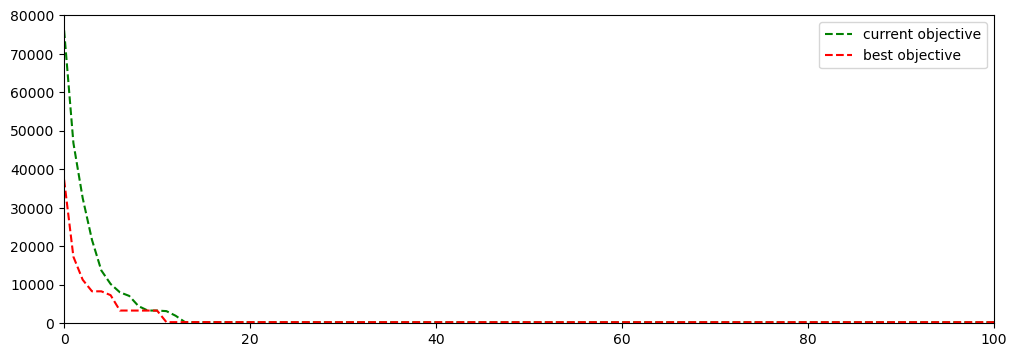

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df['iteration'], df['curr_obj'], 'g--', label="current objective")
ax.plot(df['iteration'], df['best_obj'], 'r--', label="best objective")
ax.legend()

ax.set_xlim([0, 100])
ax.set_ylim([0, 80000])